In [7]:
#imports
import json
from pprint import pprint
import scipy.optimize as optimize
import pandas as pd
import numpy as np
from datetime import datetime
from enum import Enum
import sys
import timeit
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from dateutil import tz
import gzip
from pathlib import Path
# import L4.L4 as L4

# from pandas.plotting import parallel_coordinates
# from sklearn.mixture import GaussianMixture as GMM
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import KMeans
plt.style.use('seaborn')

In [2]:
#we need to preprocess the data
def getBookContract(aStringNumberContract, aTypeOption):
    aContract = ''
    if aStringNumberContract == "000" and aTypeOption == "1":
        aContract = CONTRACTTYPE.FUTURE #replace with enums
    elif aTypeOption == "2":
        aContract = CONTRACTTYPE.CALL 
    elif aTypeOption == "3":
        aContract = CONTRACTTYPE.PUT 
    else:
        print("error, Contract Type" + str(aStringNumberContract) + " , " + str(aTypeOption) + " not recognized")
    
    return aContract

class CONTRACTTYPE(Enum):
    UNSET = 0
    FUTURE = 1
    CALL = 2
    PUT = 3

In [160]:

def getExpiryDate(aBook):
    anExpiryCode  = aBook[6:8]
    #hardcoded version for now. 
    myString_date = ''
    
    myString_year = ''
    myString_month = ''
    myString_day = ''
    
    #get year code
    if anExpiryCode[0] == 'L':
        myString_year = "2016"
    elif anExpiryCode[0] == 'M':
        myString_year = "2017"
    elif anExpiryCode[0] == 'N':
        myString_year = "2018"
    elif anExpiryCode[0] == 'P': #It looks strange, but that's KRX 
        myString_year = "2019"
    else : 
        sys.stderr.write("fatal error\n expiry year code unknown \n")
    
    #get month code
    myPotentialMonths = ['','1','2','3','4','5','6','7','8','9','A','B','C']

    if anExpiryCode[1] in myPotentialMonths:
        myString_month =  str(myPotentialMonths.index(anExpiryCode[1]))
    else : 
        sys.stderr.write("fatal error\n expiry month code unknown \n")    
    
    if myString_month == '':
        sys.stderr.write("fatal error\n expiry month code unknown \n")   
    #get day
    #get third Wednesday of every month, we will have to make bank holidays exceptions
    myString_day = str(calendar.Calendar(2).monthdatescalendar(int(myString_year), \
                                                               int(myString_month))[3][0].day)
    
#     print(myString_month)                   
    myString_date = myString_year+'-'+myString_month+'-'+myString_day+' 16:00:00'

    timeZone = tz.gettz('Asia/Seoul')
            
    #print("Don't forget bank holidays exceptions")
    return datetime.strptime(myString_date, "%Y-%m-%d %H:%M:%S").replace(tzinfo=timeZone).astimezone(timeZone)


In [69]:
#get the right time for plotting later
def utcToRightTMZ(aUTCTMZ):
    
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Asia/Seoul')
    
    aUTCTMZ = aUTCTMZ.replace(tzinfo=from_zone)
    localTimeStamp = aUTCTMZ.astimezone(to_zone)
    
    return localTimeStamp

In [5]:
#load the data
#data = json.load(open('feeddata_10.json'))

#cleaner : keeps the file compressed on the computer
with gzip.open('data\\2017.11.01\\feeddata_10.json.gz', "rb") as f:
    data = json.loads(f.read().decode("ascii"))

In [206]:
data[12]['book'][6:8]

'MB'

# Tensorflow

In [199]:
def inStrikeRange(aFutBook, aOptBook):
    '''
    look at slightly OTM or ITM options and keep that range static. Change dynamically book to keep that range
    '''
    if aFutBook == '' or aOptBook == '': #if the fut book is not itialized
        return False
    elif getBookContract(aOptBook[8:11],aOptBook[3]) is not CONTRACTTYPE.CALL : #only if Call
        return False
    
    return ((int(aOptBook[8:11]) > int(5 * np.floor((aFutBook['bid_price_0']+ aFutBook['ask_price_0'])/2/5))-5 )
    and (int(aOptBook[8:11]) < int(5 * np.ceil((aFutBook['bid_price_0']+ aFutBook['ask_price_0'])/2/5))+11))

def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    '''
    aOptionStrike: enables to initialize the book to start with
    '''
    myTicksOfInterest = np.empty(shape = (0,0))
    myCounter = 0
    myLastVol = 0
    myLastVolFut = 0
    timeOfTradeFut = 0
    myFutPrice = 0
    
    myFirstFut = True
    myFirstOpt = True
    myFutBook = ''
    myOptionBook = ''
    myPastOptionBook = ''
    myTimeList = [] #faster than nparray for appending
    
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            myTickCreatedTime = tick['created']/1000000 #vastly reused in the code
            TTM = (getExpiryDate(myBook) - utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))).total_seconds()/3600/24    

#             print(TTM)
            if(getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE):
                print(TTM)
                if tick['type']=='lastdone' and TTM<45 : 
                    print('2')
                    if myFirstFut:
                        myFutBook = myBook
                        myFirstFut = False

                    if myFutBook == myBook:
                        myLastVolFut = (0.995*myLastVol + 0.001*(tick['volume']))
                        timeOfTradeFut = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                        myFutPrice = tick['price']
                elif TTM<45:
                    myFutTick = tick
                    
            if not myFirstFut and inStrikeRange(myFutTick, myBook) and TTM<30: 
                print('3')
                    #we need to go through a first future to calculate the moneyness
                    #range we accept to look at a product (keep it not too small or it will always change book)
                myFutMid = (myFutTick['bid_price_0']+ myFutTick['ask_price_0'])/2
                #check for not initialized book or if not in range book
                if np.isnan(aOptionStrike) or not inStrikeRange(myFutTick, myOptionBook) :
                    aOptionStrike = int(5 * np.ceil(myFutMid/5))
                
                if tick['type']=='lastdone' and myBook[8:11]==str(aOptionStrike):

                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False

#                     if myOptionBook == myBook:   
                    myLastVol = (0.995*myLastVol + 0.0007*(tick['volume']))
                    timeOfTrade = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
        
                if tick['type']=='tick'  and myBook[8:11]==str(aOptionStrike):
                    
                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False
                        myPastOptionBook = tick
                        
                        myOldTime = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                        myIniSeconds = np.floor(myTickCreatedTime)

                                        #only interested in first 2 levels  
                    
                    if (tick['ask_volume_0'] != myPastOptionBook['ask_volume_0']) or \
                        (tick['ask_volume_1'] != myPastOptionBook['ask_volume_1']) or \
                        (tick['bid_volume_0'] != myPastOptionBook['bid_volume_0']) or \
                        (tick['bid_volume_1'] != myPastOptionBook['bid_volume_1']):
#                         print(aOptionStrike, myFutMid)                    

                        myPastOptionBook = tick
                        
                        
                        currTime = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                            #keep in mind the time second per sec
                        
                        myTimeList.append(myTickCreatedTime-myIniSeconds)
                        myCounter += 1
                        
                        #Using a ring buffer wouldn't work ... so :
                        myC3=0
                        myC1=0
                        myC05=0
                        myC025=0
                        myC01=0
                        myIdxToStartForClean=0
                        for idx,dtStart in enumerate(myTimeList): #I know, could do better
                            dtRecent = myTimeList[-1] - dtStart
                            if dtRecent>=3:
                                myIdxToStartForClean = idx
                            elif dtRecent<3:
                                myC3 +=1
                            elif dtRecent<1:
                                myC1 +=1   
                            elif dtRecent<0.5:
                                myC05 +=1 
                            elif dtRecent<0.25:
                                myC025 +=1 
                            elif dtRecent<0.1:
                                myC01 +=1
                            elif dtRecent<0:
                                print("issue, dt<0")
                                
                        myTimeList = myTimeList[myIdxToStartForClean:] #clean the list
                        
                        try:
                            
                            
                            timeOfDay = currTime.hour \
                                        +currTime.minute/60
                                
                            moneyness = 2*myFutMid/int(aOptBook[8:11])
                            
                            if len(myTicksOfInterest) == 0 :
                                myTicksOfInterest = np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                              15*myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000) , \
                                                              40*myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000),\
                                                             TTM, timeOfDay, moneyness, myC3, myC1, myC05, myC025, myC01])
                            else:
                                myTicksOfInterest = np.vstack( (myTicksOfInterest,np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                                                            15*myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000), \
                                                                                            40*myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000),
                                                                                           TTM, timeOfDay, moneyness, myC3, myC1, myC05, myC025, myC01])) )

                        except Exception as e:
                            print(e)
                            pass #pass, not continue, continue switch to the next itirqtion
                        oldTime = currTime
                    
        if myCounter > nbOfDataPoints_:
            break
    return myTicksOfInterest

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * np.floor((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

In [28]:
import tensorflow as tf
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()
tf.reset_default_graph()

In [200]:
WaitingTimeAndTrade = extractInterestingData(5000,whichStrikeAtMoney(data),data)
#because of the exponential ,oving average, we want to cut the first bit of data out
WaitingTimeAndTrade= WaitingTimeAndTrade[1000:]

49.24999963043982
49.24999962952546
49.24999932187501
49.24999786556714
49.24999786556714
49.249997837800926
49.2499978237037
49.24999782082176
49.24999777775463
49.24999757153935
49.2499958766088
49.2499958766088
49.24999514791667
49.24999514791667
49.249994868622686
49.249994849710646
49.249994832395835
49.249994815127316
49.249994814085646
49.24999480890046
49.24999479819445
49.24999479493055
49.24999476974537
49.24999458111111
49.24999458111111
49.24999455888889
49.2499943697801
49.2499943697801
49.24999434547453
49.24999434172454
49.24999431660879
49.24999431660879
49.24999429646991
49.24999428903936
49.24999361765046
49.24999361765046
49.24999339174769
49.24999338886574
49.24999338797454
49.249993219398156
49.249993219398156
49.24999319799769
49.24999319799769
49.24999319459491
49.24999316258101
49.24999316165509
49.24999314210648
49.24999313984953
49.24999251734954
49.24999249706019
49.249992482812495
49.24999245960648
49.24999237126158
49.24999235468749
49.24999231511574
49.249

49.24980483199074
49.24980481394675
49.249804300034725
49.249804284097216
49.24980426087962
49.249804220428246
49.24980419141204
49.24980417422453
49.2498041721875
49.24980416491898
49.24980414707176
49.24980414612268
49.24980407706019
49.24980404521991
49.24980123015046
49.24979262396991
49.2497918554051
49.24979030678241
49.24979030678241
49.24979011157408
49.24979011157408
49.24979006712963
49.24979004762732
49.24978983393519
49.24978983393519
49.24978820221065
49.24978720163194
49.249784690914346
49.24978353116899
49.24978246025463
49.24978080466435
49.24977903812499
49.24977011975694
49.24977010875
49.249768846030086
49.24976884090278
49.2497688400463
49.2497688267014
49.24976882561342
49.249768823819444
49.24976868060185
49.24976863347223
49.24976838827546
49.24976230939814
49.24976184835648
49.24975982253472
49.249755741423606
49.24975479913194
49.24975478126157
49.24974795719908
49.24974795719908
49.24974781530093
49.24974681829861
49.24974524565972
49.24974524565972
49.2497452

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Training Data for TensorFlow')
plt.plot(WaitingTimeAndTrade)
plt.show()

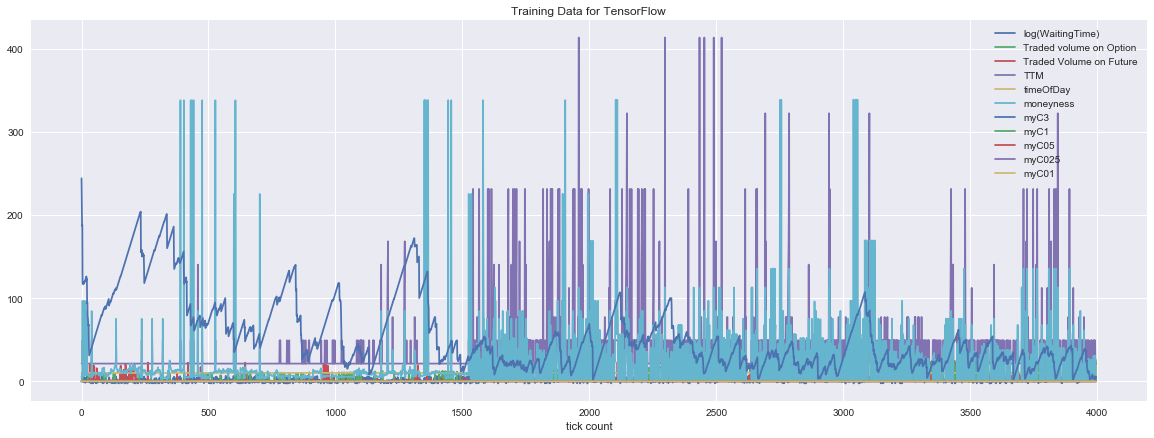

In [168]:
plt.figure(figsize=(20,7))
plt.title('Training Data for TensorFlow')
plt.plot(WaitingTimeAndTrade)
plt.legend(['log(WaitingTime)','Traded volume on Option','Traded Volume on Future','TTM', 'timeOfDay', 'moneyness', 'myC3', 'myC1', 'myC05', 'myC025', 'myC01'])
plt.xlabel('tick count')
plt.show()

In [43]:
tf.reset_default_graph()

In [61]:
# Just one feature, the time series
num_inputs = 3
# 100 neuron layer, play with this
num_neurons = 300
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0003
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 50000
# Size of the batch of data
batch_size = 300

# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 30

epsilon = tf.constant(0.1, name='epsilon')

X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])
isTrainning = tf.placeholder(tf.bool, shape=(), name="isTraining")


In [62]:
tf.all_variables()

Instructions for updating:
Please use tf.global_variables instead.


[]

In [63]:

with tf.name_scope("normalization_Calculation"):
    batch_mean1, batch_var1 = tf.nn.moments(X,[0])
    X = (X - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
    batch_mean2, batch_var2 = tf.nn.moments(y,[0])
    y = (y - batch_mean2) / tf.sqrt(batch_var2+ epsilon) #fine for training, not for testing
    
lstmCells = []
with tf.name_scope("LSTMcells2"):
    n_layers = 1
    myLstmForDrop = tf.contrib.rnn.LSTMCell(num_units=num_neurons, state_is_tuple=True,reuse=tf.get_variable_scope().reuse, \
                                           activation = tf.nn.elu)
    lstmCells.append(tf.contrib.rnn.DropoutWrapper(cell=myLstmForDrop, output_keep_prob=0.6))
    lstmCells.extend([tf.contrib.rnn.LSTMCell(num_units=num_neurons, state_is_tuple=True,reuse=tf.get_variable_scope().reuse, \
                                             activation = tf.nn.elu)
          for layer in range(n_layers-1)])
    myLstmForDrop = tf.contrib.rnn.LSTMCell(num_units=num_neurons, state_is_tuple=True,reuse=tf.get_variable_scope().reuse, \
                                           activation = tf.nn.elu)
    lstmCells.append(tf.contrib.rnn.DropoutWrapper(cell=myLstmForDrop, output_keep_prob=0.5))

    cell = tf.contrib.rnn.MultiRNNCell(lstmCells)
#     outputs, states = tf.nn.dynamic_rnn(cell, batch_norm(X, 'XBatch', True), dtype=tf.float32)
    outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    
    
    
with tf.variable_scope("LSTM_V2") as vs:
    lstm_variables = []
    for v in tf.all_variables():
        if v.name.startswith("rnn/multi_rnn_cell/"):
#             print(v)
            lstm_variables.append(v)
    for v in lstm_variables:
        tf.summary.histogram(str(v), v)
tf.initialize_variables(lstm_variables)


with tf.name_scope("loss2"):
#     loss = tf.reduce_mean(tf.square(outputs - batch_norm(y, 'yBatch', True))) # MSE
    loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
    tf.summary.scalar('loss', loss)
with tf.name_scope("train2"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#     optimizer = L4.L4Adam()
    train = optimizer.minimize(loss)

init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
saver = tf.train.Saver()


Instructions for updating:
Please use tf.global_variables instead.
INFO:tensorflow:Summary name <tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/weights:0' shape=(303, 1200) dtype=float32_ref> is illegal; using _tf.Variable__rnn/multi_rnn_cell/cell_0/lstm_cell/weights_0__shape__303__1200__dtype_float32_ref_ instead.
INFO:tensorflow:Summary name <tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/biases:0' shape=(1200,) dtype=float32_ref> is illegal; using _tf.Variable__rnn/multi_rnn_cell/cell_0/lstm_cell/biases_0__shape__1200___dtype_float32_ref_ instead.
INFO:tensorflow:Summary name <tf.Variable 'rnn/multi_rnn_cell/cell_1/lstm_cell/weights:0' shape=(600, 1200) dtype=float32_ref> is illegal; using _tf.Variable__rnn/multi_rnn_cell/cell_1/lstm_cell/weights_0__shape__600__1200__dtype_float32_ref_ instead.
INFO:tensorflow:Summary name <tf.Variable 'rnn/multi_rnn_cell/cell_1/lstm_cell/biases:0' shape=(1200,) dtype=float32_ref> is illegal; using _tf.Variable__rnn/multi_rnn_cell/cell_1/lstm_ce

In [64]:
def next_batch(data,batch_size,steps,return_index=False):
    nbLabels = data.shape[1]
    # Grab a random starting point for each batch
    rand_start = rand_start = np.random.randint(len(data)-steps, size=(batch_size,1), dtype = 'int32') #int16 might not be enough

    # Create batch Time Series on occurences (t)
    batch_indices = rand_start + np.arange(0,steps+1)
    
    x_batch = data[batch_indices]
#     x_batch =  (x_batch-np.mean(x_batch))/np.std(x_batch) #we need to to the normalization inside tf framework to ease
#     x_batch = batch_norm(x_batch, 'batchNorm', True)
#     # Format for RNN
#     if return_index:
#         return x_batch[:, :-1, :].reshape(batch_size, steps, nbLabels), x_batch[:, 1:, :1].reshape(batch_size, steps, 1) ,batch_indices

#     else:
    return x_batch[:, :-1, :].reshape(batch_size, steps, nbLabels), x_batch[:, 1:, :1].reshape(batch_size, steps, 1)

In [67]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    tf.summary.FileWriterCache.clear()
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter('C:\\Users\\Hal9000-ti\\ML_MiniProjects\\TensorBoard\\1',graph = sess.graph)  # create writer

        

    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(WaitingTimeAndTrade, batch_size, num_time_steps)

        if iteration % 100 == 0:   
            s = sess.run(merged_summary, feed_dict={X: X_batch, y: y_batch})
            writer.add_summary(s,iteration)
        if iteration % 500 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch, isTrainning:True})
            print(iteration, "\tMSE:", mse)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
       
        if iteration % 15000 == 0:
            saver.save(sess, "./rnn_time_series_model_Batched1")

    

0 	MSE: 6.26307
500 	MSE: 5.47765
1000 	MSE: 5.543
1500 	MSE: 5.21173
2000 	MSE: 5.28622
2500 	MSE: 5.41094
3000 	MSE: 4.95668
3500 	MSE: 4.82984
4000 	MSE: 4.62782
4500 	MSE: 4.69676
5000 	MSE: 4.84697
5500 	MSE: 4.6935
6000 	MSE: 4.56565
6500 	MSE: 4.4422
7000 	MSE: 4.5462
7500 	MSE: 4.4231
8000 	MSE: 4.40182
8500 	MSE: 4.51645
9000 	MSE: 4.42836
9500 	MSE: 4.32409
10000 	MSE: 4.1937
10500 	MSE: 4.43308
11000 	MSE: 4.22623
11500 	MSE: 4.17844
12000 	MSE: 4.22834
12500 	MSE: 4.17434
13000 	MSE: 4.14891
13500 	MSE: 4.34371
14000 	MSE: 4.22826
14500 	MSE: 4.26509
15000 	MSE: 4.24658
15500 	MSE: 4.18528
16000 	MSE: 4.17876
16500 	MSE: 4.13422
17000 	MSE: 4.01826
17500 	MSE: 4.08165
18000 	MSE: 4.19138
18500 	MSE: 3.97883
19000 	MSE: 3.9124
19500 	MSE: 3.99912
20000 	MSE: 4.32369
20500 	MSE: 3.90404
21000 	MSE: 4.00632
21500 	MSE: 4.03253
22000 	MSE: 4.06106
22500 	MSE: 3.98678
23000 	MSE: 4.00111
23500 	MSE: 3.99921
24000 	MSE: 3.9035
24500 	MSE: 3.84268
25000 	MSE: 4.00034
25500 	MSE: 3

In [68]:
def residualExpoMovingAverage(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade[:,0]):
            counter = counter + 1
            if not first:
                errs.append((waitingTime - ExpectedTime)*(waitingTime - ExpectedTime))
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
            else:
                if counter  > 2:
                    ExpectedTime = waitingTime
                    first = False
            
    return np.mean(errs[1:])

res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print(res_bench2.fun)



C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


5.071988761388267


In [75]:
WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)
WaitingTimeAndTrade_test = WaitingTimeAndTrade_test[10000:]

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
unsupported operand type(s) for -: 'datetime.datetime' and 'int'


In [76]:
def returnPred_test(aParam,startTime) : 
    pred = []
    first = True
    counter = 0
    ExpectedTime = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0][startTime-10:startTime+num_time_steps][:-1]):

                ExpectWaitingTimeAndTrade_testedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
                if idx>9:
                    pred.append(ExpectedTime)
            
    return pred

In [77]:

def showOtherGraph_squared():
    startTime = np.random.randint(len(WaitingTimeAndTrade_test)-num_time_steps-10,size=())+10
    nbLabels = WaitingTimeAndTrade_test.shape[1]
    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model_Batched1")   
        X_new = np.array(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps, :].reshape(-1, num_time_steps, nbLabels))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        
       
    return np.average(np.square(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])) ,\
            np.average(np.square(returnPred_test(res_bench2.x,startTime) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0]))

In [78]:

WaitingTimeAndTrade_test = WaitingTimeAndTrade
error_lstm_dist = np.empty(shape = (0,0))
error_expo_dist = np.empty(shape = (0,0))

for i in range(0,1000):
    error_lstm, error_expo = showOtherGraph_squared()
    error_lstm_dist= np.append(error_lstm_dist,error_lstm)
    error_expo_dist = np.append(error_expo_dist,error_expo)

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

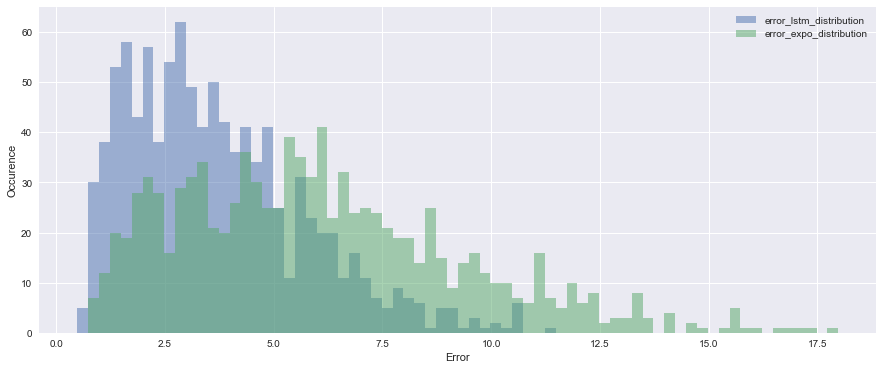

,error_lstm_distribution,error_expo_distribution
count,1000.000000,1000.000000
mean,3.686080,6.040087
std,2.037005,3.250778
min,0.485445,0.800078
25%,2.077396,3.465944
50%,3.301242,5.633689
75%,4.836360,7.927961
max,11.257191,17.980029


In [79]:
plt.style.use('seaborn')
df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])



df_testRest.plot.hist(alpha = 0.5, bins=70,figsize=(15,6))
plt.xlabel('Error')
plt.ylabel('Occurence')
plt.legend()
plt.show()

df_testRest.describe()

# True test

In [80]:
with gzip.open('data\\2017.11.01\\feeddata_11.json.gz', "rb") as f:
    data = json.loads(f.read().decode("ascii"))
WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)

local variable 'oldTime' referenced before assignment


In [84]:

def showOtherGraph_test_squared():
    startTime = np.random.randint(len(WaitingTimeAndTrade_test)-num_time_steps,size=())
    nbLabels = WaitingTimeAndTrade_test.shape[1]
    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model_Batched1")   
        X_new = np.array(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps, :].reshape(-1, num_time_steps, nbLabels))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    return np.average(np.square(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])) ,\
            np.average(np.square(returnPred_test(res_bench2.x,startTime) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0]))

In [85]:


error_lstm_dist_test = np.empty(shape = (0,0))
error_expo_dist_test = np.empty(shape = (0,0))
for i in range(0,1000):
    error_lstm, error_expo = showOtherGraph_test_squared()
    try:
        error_lstm_dist_test= np.append(error_lstm_dist_test,error_lstm)
        error_expo_dist_test = np.append(error_expo_dist_test,error_expo)
    except:
        pass

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_Batched1
INFO:tensorflow:Restoring

ValueError: operands could not be broadcast together with shapes (0,) (29,) 

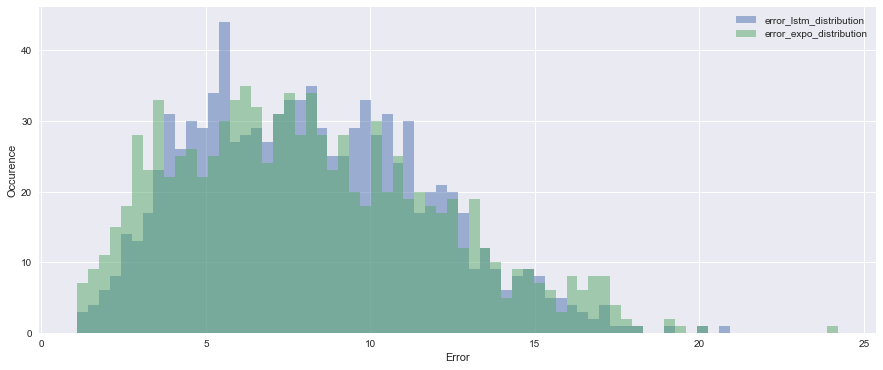

,error_lstm_distribution,error_expo_distribution
count,964.000000,964.000000
mean,8.208705,8.129951
std,3.532401,3.948623
min,1.181360,1.091750
25%,5.419204,5.102398
50%,7.966140,7.687119
75%,10.640994,10.829664
max,20.675510,24.221507


In [86]:
plt.style.use('seaborn')
df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist_test,error_expo_dist_test]), columns=['error_lstm_distribution', "error_expo_distribution"])



df_testRest.plot.hist(alpha = 0.5, bins=70,figsize=(15,6))
plt.xlabel('Error')
plt.ylabel('Occurence')
plt.legend()
plt.show()

df_testRest.describe()